In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

## extra imports to set GPU options
import tensorflow as tf
 
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.33
 
# Create a session with the above options specified.
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [2]:
def embeddings(word_index, input_dim, input_length, path="/home/hellrich/keras-test/embeddings/glove.6B.", suffix="d.txt",
               embedding_dim=200, trainable=False):
    def load_embedding_text(dim):
        w2e = {}
        for line in open(path+str(dim)+suffix):
            line = line.strip().split(" ")
            if len(line) > 2:
                w = line[0]
                e = np.asarray(line[1:], dtype="float32")
                w2e[w] = e
        return w2e
    
    index2word = {v : k for k, v in word_index.items()}
    weights = np.zeros((input_dim, embedding_dim))
    loaded = load_embedding_text(embedding_dim)
    entries = 0
    for i in range(1,input_dim):
        w = index2word[i]
        if w in loaded:
            weights[i] = np.array(loaded[w])
            entries += 1
    print("entries", entries, "found for", input_dim, "words in embedding model")
    return Embedding(input_dim, embedding_dim, weights=[weights], 
                     input_length=input_length, trainable=trainable)  #input_dim + 1 ?

In [3]:
from enum import Enum
class ToProcess(Enum):
    TEXT_ONLY=1
    TITLE_ONLY=2
    BOTH=3

def read_data(data_file = "20180622processedGoldStandardTopics.tsv", preprocess=True, 
              shuffle=False, maxlen=None, vocab_size=None, bow_mode=None, to_process=ToProcess.BOTH,
              fold_repeats=True, return_word_index=False, sentence_wise=None):
    texts = []
    labels = []
    with open(data_file) as data_file:
        line_number = 0
        for line in data_file:
            if line_number > 0:
                number, trec_topic_number, trec_doc_id, pm_rel_desc, disease_desc, \
                gene1_annotation_desc, gene1_name, gene2_annotation_desc, \
                gene2_name, gene3_annotation_desc, gene3_name, demographics_desc, \
                other_desc, relevance_score, title, abstract, major_mesh, \
                minor_mesh, trec_topic_disease, trec_topic_age, trec_topic_sex, \
                trec_topic_other1, trec_topic_other2, trec_topic_other3 = line.split("\t")
                if to_process == ToProcess.BOTH:
                    text = title.replace("[","").replace("]","") + " " + abstract
                elif to_process == ToProcess.TEXT_ONLY:
                    text = abstract
                elif to_process == ToProcess.TITLE_ONLY:
                    text = title.replace("[","").replace("]","")
                else:
                    raise Exception("not implemented")
                if preprocess:
                    text = text.lower().replace(". ", " . ").replace(", ", " , ").\
                        replace("? ", " ? ").replace("! ", " ! ")
                texts.append(text)
                
                if pm_rel_desc == 'Human PM' or pm_rel_desc == 'Animal PM':
                    labels.append(1.)
                else:
                    labels.append(0.)
            line_number += 1
               
       
    if fold_repeats:
        text2indices = {}
        for i, text in enumerate(texts):
            if text in text2indices:
                text2indices[text].append(i)
            else:
                text2indices[text] = [i]
        for text, indices in text2indices.items():
            if len(indices) > 1:
                is_pm = False
                for i in indices:
                    if labels[i] == 1.:
                        is_pm = True
                #remove all but first
                for i in indices[1:]:
                    labels[i] = None
                    texts[i] = None
                if is_pm:
                    labels[indices[0]] = 1.
        texts = [t for t in texts if t is not None]
        labels = [x for x in labels if x is not None]
                        
    labels = np.array(labels)  
    
    #see https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
    t = Tokenizer(num_words=vocab_size)
    t.fit_on_texts(texts)
    if bow_mode:
        #modes:
        #‘binary‘: Whether or not each word is present in the document. This is the default.
        #‘count‘: The count of each word in the document.
        #‘tfidf‘: The Text Frequency-Inverse DocumentFrequency (TF-IDF) scoring for each word in the document.
        #‘freq‘: The frequency of each word as a ratio of words within each document.
        texts = t.texts_to_matrix(texts, mode=bow_mode)
        if sentence_wise:
            raise Exception("bow_mode and sentence_wise are incompatible")
        if maxlen:
            texts = keras.preprocessing.sequence.pad_sequences(texts, maxlen=maxlen)
    else:
        if sentence_wise:
            if not preprocess:
                raise Exception("preprocess required")
            max_sentences = sentence_wise[0]
            max_sentence_length = sentence_wise[1]
            list_of_list_of_sentences = [text.split(" . ") for text in texts]
            #trimming number of sentences
            trimmed_list_of_list_of_sentences = []
            for x in list_of_list_of_sentences:
                if len(x) > max_sentences:
                    trimmed_list_of_list_of_sentences.append(x[:max_sentences])
                else:
                    if len(x) < max_sentences:
                        to_pad = max_sentences - len(x)
                        for i in range(to_pad):
                            x.append([" "])
                    trimmed_list_of_list_of_sentences.append(x)
            list_of_sentence_matrices = [t.texts_to_sequences(x) for x in trimmed_list_of_list_of_sentences]
            #trimming sentences for length
            trimmed_list_of_sentence_matrices = [keras.preprocessing.sequence.pad_sequences(
                                x, maxlen = max_sentence_length) for x in list_of_sentence_matrices]
            texts = np.asarray(trimmed_list_of_sentence_matrices)
        else:
            texts = t.texts_to_sequences(texts)
            if maxlen:
                texts = keras.preprocessing.sequence.pad_sequences(texts, maxlen=maxlen)
    
    if shuffle:
        perm = np.random.permutation(len(texts))
        texts = texts[perm]
        labels = labels[perm]
    if return_word_index:
        return texts, labels, t.word_index
    else:
        return texts, labels

In [26]:
class FineTuneLayer(keras.callbacks.Callback):
    ''' 
        n_epoch = no. of epochs after decay should happen.
        decay = decay value
        lyaer_nr = layer to unfreeze
        verbose = if non-zero there will be a message
    '''  
    def __init__(self, n_epoch, decay, layer_nr, verbose=1):
        super(FineTuneLayer, self).__init__()
        self.n_epoch = n_epoch
        self.decay = decay
        self.layer_nr = layer_nr
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs={}):
        if epoch == self.n_epoch:
            lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.decay
            keras.backend.set_value(self.model.optimizer.lr, lr)
            self.model.layers[self.layer_nr].trainable = True
            if self.verbose:
                print("Finetuning layer", self.layer_nr, "decreased learning rate with", self.decay)
            

def experiment(model, texts, labels, max_epochs=30, patience=4, 
               fine_tune_embeddings=False, validation_split=0.1, learning_rate=0.001):
    model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate),
                metrics=['acc'])
    
    callbacks = []

    if fine_tune_embeddings:
        callbacks.append(FineTuneLayer(fine_tune_embeddings[0], fine_tune_embeddings[1], 1))
    
    if patience:
        if patience > 2:
            callbacks.append(keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.1,
                    patience=patience - 2,
                    verbose=1
                 ))
        callbacks.append(keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                verbose=1
             ))
    
    history = model.fit(texts, labels, validation_split=validation_split, epochs=max_epochs, 
                        batch_size=50, verbose=2, callbacks=callbacks).history
    
    epochs = range(1, len(history["acc"]) + 1)
    plt.plot(epochs, history["val_acc"], label="val accurarcy")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
maxlen = 300
vocab_size = 40000

Train on 16839 samples, validate on 1871 samples
Epoch 1/30
 - 5s - loss: 0.5770 - acc: 0.7060 - val_loss: 0.5788 - val_acc: 0.7018
Epoch 2/30
 - 4s - loss: 0.4791 - acc: 0.7813 - val_loss: 0.5738 - val_acc: 0.6970
Epoch 3/30
 - 4s - loss: 0.4311 - acc: 0.8135 - val_loss: 0.6099 - val_acc: 0.6788
Epoch 4/30
 - 4s - loss: 0.3962 - acc: 0.8376 - val_loss: 0.5945 - val_acc: 0.6873

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
 - 4s - loss: 0.3637 - acc: 0.8615 - val_loss: 0.6046 - val_acc: 0.6804
Epoch 6/30
 - 4s - loss: 0.3609 - acc: 0.8636 - val_loss: 0.6057 - val_acc: 0.6799

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00006: early stopping


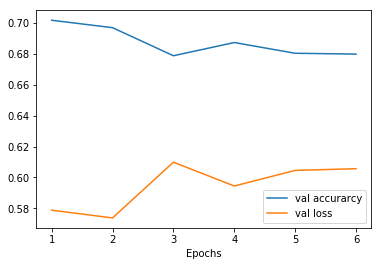

Train on 16839 samples, validate on 1871 samples
Epoch 1/30
 - 4s - loss: 0.7250 - acc: 0.6360 - val_loss: 0.6624 - val_acc: 0.6921
Epoch 2/30
 - 4s - loss: 0.6511 - acc: 0.6980 - val_loss: 0.6501 - val_acc: 0.7002
Epoch 3/30
 - 3s - loss: 0.6324 - acc: 0.7131 - val_loss: 0.6392 - val_acc: 0.7039
Epoch 4/30
 - 4s - loss: 0.6201 - acc: 0.7175 - val_loss: 0.6337 - val_acc: 0.7018
Epoch 5/30
 - 4s - loss: 0.6111 - acc: 0.7239 - val_loss: 0.6294 - val_acc: 0.6986
Epoch 6/30
 - 3s - loss: 0.6041 - acc: 0.7257 - val_loss: 0.6254 - val_acc: 0.6986
Epoch 7/30
 - 4s - loss: 0.5986 - acc: 0.7284 - val_loss: 0.6265 - val_acc: 0.6948
Epoch 8/30
 - 4s - loss: 0.5940 - acc: 0.7312 - val_loss: 0.6233 - val_acc: 0.6991
Epoch 9/30
 - 4s - loss: 0.5902 - acc: 0.7322 - val_loss: 0.6229 - val_acc: 0.6970
Epoch 10/30
 - 3s - loss: 0.5871 - acc: 0.7318 - val_loss: 0.6226 - val_acc: 0.6964
Epoch 11/30
 - 3s - loss: 0.5843 - acc: 0.7334 - val_loss: 0.6220 - val_acc: 0.6975
Epoch 12/30
 - 4s - loss: 0.5818 - a

KeyboardInterrupt: 

In [28]:
#logistic regression, see https://gist.github.com/fchollet/b7507f373a3446097f26840330c1c378
bow_texts, bow_labels = read_data(vocab_size=vocab_size, bow_mode="binary")
#texts, labels = read_data(vocab_size=vocab_size, bow_mode="binary", to_process=ToProcess.TITLE_ONLY)

model = Sequential()
#worked better without regularizer: kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
model.add(Dense(1, activation='sigmoid', 
                input_dim=vocab_size))

experiment(model, bow_texts, bow_labels)

model = Sequential()
model.add(Dense(1, activation='sigmoid', 
                kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001),
                input_dim=vocab_size))
experiment(model, bow_texts, bow_labels, learning_rate=0.0001)

In [22]:
#reclassification for logistic regression, see https://gist.github.com/fchollet/b7507f373a3446097f26840330c1c378
bow_texts, bow_labels = read_data(vocab_size=vocab_size, bow_mode="binary")
#texts, labels = read_data(vocab_size=vocab_size, bow_mode="binary", to_process=ToProcess.TITLE_ONLY)

model = Sequential()
#worked better without regularizer: kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
model.add(Dense(1, activation='sigmoid', 
                input_dim=vocab_size))

model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['acc'])
    
model.fit(bow_texts, bow_labels, epochs=5, 
                        batch_size=50, verbose=2)

model.evaluate(bow_texts, bow_labels)

Epoch 1/5
 - 5s - loss: 0.5752 - acc: 0.7076
Epoch 2/5
 - 4s - loss: 0.4805 - acc: 0.7769
Epoch 3/5
 - 4s - loss: 0.4339 - acc: 0.8075
Epoch 4/5
 - 4s - loss: 0.4004 - acc: 0.8304
Epoch 5/5
 - 4s - loss: 0.3729 - acc: 0.8509
18710/18710 [==============================] - 3s 186us/step


[0.34352686213402106, 0.8718332442862665]

Train on 16839 samples, validate on 1871 samples
Epoch 1/30
 - 4s - loss: 0.5515 - acc: 0.7190 - val_loss: 0.6067 - val_acc: 0.6788
Epoch 2/30
 - 3s - loss: 0.4336 - acc: 0.8069 - val_loss: 0.5937 - val_acc: 0.6889
Epoch 3/30
 - 3s - loss: 0.3751 - acc: 0.8474 - val_loss: 0.6236 - val_acc: 0.6697
Epoch 4/30
 - 3s - loss: 0.3340 - acc: 0.8727 - val_loss: 0.6298 - val_acc: 0.6718

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
 - 3s - loss: 0.2901 - acc: 0.9050 - val_loss: 0.6379 - val_acc: 0.6627
Epoch 6/30
 - 3s - loss: 0.2868 - acc: 0.9068 - val_loss: 0.6339 - val_acc: 0.6670

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00006: early stopping


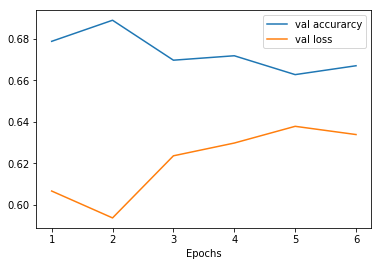

In [14]:
#logistic regression with 2 class softmax instead, see https://gist.github.com/fchollet/b7507f373a3446097f26840330c1c378
#texts, labels = read_data(vocab_size=vocab_size, bow_mode="binary", to_process=ToProcess.TITLE_ONLY)
labels = []
for b in bow_labels:
    if b:
        labels.append([0., 1.])
    else:
        labels.append([1., 0.])
labels = np.asarray(labels)

model = Sequential()
#worked better without regularizer: kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
model.add(Dense(2, activation='softmax', 
                input_dim=vocab_size))

model.compile(loss='categorical_crossentropy',
                optimizer="adam",
                metrics=['acc'])
callbacks = [keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.1,
                    patience=2,
                    verbose=1
                 ),
        keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=4,
                verbose=1
             )]
history = model.fit(bow_texts, labels, validation_split=0.1, epochs=30, 
                        batch_size=50, verbose=2, callbacks=callbacks).history
    
epochs = range(1, len(history["acc"]) + 1)
plt.plot(epochs, history["val_acc"], label="val accurarcy")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [8]:
#text and labels in embedding format
texts, labels, word_index = read_data(maxlen=maxlen, vocab_size=vocab_size, return_word_index=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 20)           800000    
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6001      
Total params: 806,001
Trainable params: 806,001
Non-trainable params: 0
_________________________________________________________________


/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1871 samples
Epoch 1/30
 - 3s - loss: 0.7314 - acc: 0.5343 - val_loss: 0.6567 - val_acc: 0.5986
Epoch 2/30
 - 2s - loss: 0.6316 - acc: 0.6386 - val_loss: 0.7972 - val_acc: 0.4912
Epoch 3/30
 - 2s - loss: 0.5344 - acc: 0.7258 - val_loss: 0.5856 - val_acc: 0.6825
Epoch 4/30
 - 2s - loss: 0.4662 - acc: 0.7758 - val_loss: 0.6781 - val_acc: 0.6472
Epoch 5/30
 - 1s - loss: 0.4171 - acc: 0.8046 - val_loss: 0.6540 - val_acc: 0.6627

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
 - 2s - loss: 0.3515 - acc: 0.8517 - val_loss: 0.6475 - val_acc: 0.6676
Epoch 7/30
 - 2s - loss: 0.3436 - acc: 0.8588 - val_loss: 0.5968 - val_acc: 0.6948

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00007: early stopping


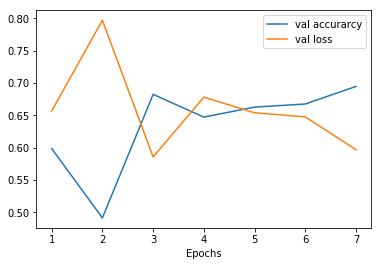

In [9]:
#simple embedding net
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=maxlen))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()
experiment(model, texts, labels)

In [65]:
#simple embedding with pre-trained embeddings
model = Sequential()
model.add(embeddings(word_index, input_dim=vocab_size, input_length=maxlen, embedding_dim=200))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
#model.layers[1].trainable=False
model.summary()
experiment(model, texts, labels)

ValueError: Layer weight shape (40001, 200) not compatible with provided weight shape (40000, 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 20)           800000    
_________________________________________________________________
dropout_12 (Dropout)         (None, 300, 20)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 296, 128)          12928     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total para

/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/100
 - 3s - loss: 0.6934 - acc: 0.5382 - val_loss: 0.6822 - val_acc: 0.6469
Epoch 2/100
 - 2s - loss: 0.6801 - acc: 0.5677 - val_loss: 0.6460 - val_acc: 0.6229
Epoch 3/100
 - 2s - loss: 0.6051 - acc: 0.6708 - val_loss: 0.6059 - val_acc: 0.6485
Epoch 4/100
 - 2s - loss: 0.5301 - acc: 0.7247 - val_loss: 0.5828 - val_acc: 0.6538
Epoch 5/100
 - 2s - loss: 0.4999 - acc: 0.7473 - val_loss: 0.6013 - val_acc: 0.6640
Epoch 6/100
 - 2s - loss: 0.4811 - acc: 0.7594 - val_loss: 0.5858 - val_acc: 0.6581
Epoch 7/100
 - 2s - loss: 0.4572 - acc: 0.7762 - val_loss: 0.5927 - val_acc: 0.6741
Epoch 8/100
 - 2s - loss: 0.4391 - acc: 0.7864 - val_loss: 0.5973 - val_acc: 0.6768
Epoch 9/100
 - 2s - loss: 0.4207 - acc: 0.8002 - val_loss: 0.5904 - val_acc: 0.6795
Epoch 10/100
 - 2s - loss: 0.4019 - acc: 0.8145 - val_loss: 0.6616 - val_acc: 0.6864
Epoch 11/100
 - 2s - loss: 0.3802 - acc: 0.8270 - val_loss: 0.6283 - val_acc: 0.6928
Epoch 12/100
 - 2s - loss

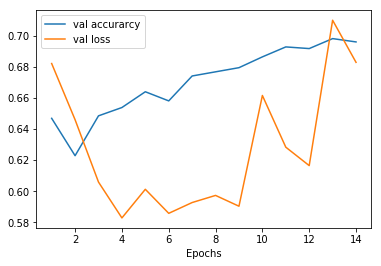

In [34]:
#convolution a la sven
embedding_dimensions=20
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dimensions, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
experiment(model, texts, labels, 100, 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 300, 200)          8000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 200)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 296, 128)          128128    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total para

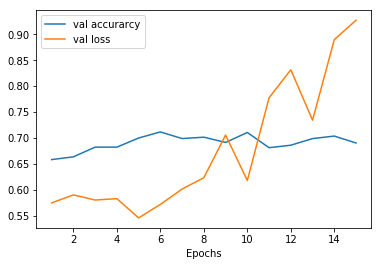

In [63]:
#convolution a la sven with pretrained
embedding_dimensions=20
model = Sequential()
model.add(embeddings(word_index, input_dim=vocab_size, input_length=maxlen, embedding_dim=200))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
experiment(model, texts, labels, 100, 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 300, 20)           800000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 296, 64)           6464      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 806,529
Trainable params: 806,529
Non-trainable params: 0
_________________________________________________________________


/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/30
 - 3s - loss: 0.6833 - acc: 0.5652 - val_loss: 0.6245 - val_acc: 0.6635
Epoch 2/30
 - 2s - loss: 0.5975 - acc: 0.6790 - val_loss: 0.5873 - val_acc: 0.6672
Epoch 3/30
 - 2s - loss: 0.5257 - acc: 0.7329 - val_loss: 0.5740 - val_acc: 0.6624
Epoch 4/30
 - 2s - loss: 0.4702 - acc: 0.7725 - val_loss: 0.6016 - val_acc: 0.6709
Epoch 5/30
 - 2s - loss: 0.4243 - acc: 0.8046 - val_loss: 0.5816 - val_acc: 0.6848

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
 - 2s - loss: 0.3719 - acc: 0.8442 - val_loss: 0.5943 - val_acc: 0.6784
Epoch 7/30
 - 2s - loss: 0.3639 - acc: 0.8462 - val_loss: 0.5841 - val_acc: 0.6880

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00007: early stopping


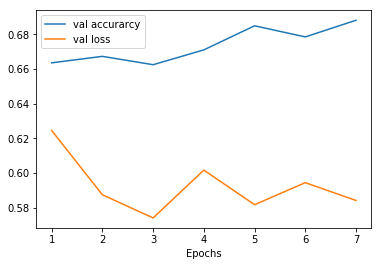

In [68]:
#simple convolution
embedding_dimensions=20
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dimensions, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()
experiment(model, texts, labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 300, 200)          8000000   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 296, 64)           64064     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 8,064,129
Trainable params: 64,129
Non-trainable params: 8,000,000
_________________________________________________________________
Train on 16839 samples, validate on 1872 samples
Epoch 1/30
 - 2s - loss: 0.6123 - acc: 0.6679 - val_loss: 0.5571 - val_acc: 0.

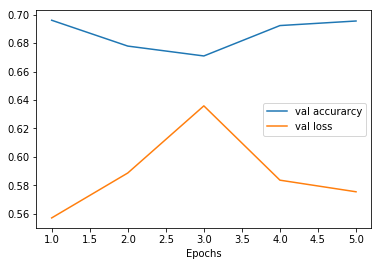

In [69]:
#simple convolution pretrained
embedding_dimensions=20
model = Sequential()
model.add(embeddings(word_index, input_dim=vocab_size, 
                    input_length=maxlen, embedding_dim=200))
model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()
experiment(model, texts, labels)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 300, 20)           800000    
_________________________________________________________________
average_pooling1d_1 (Average (None, 15, 20)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 301       
Total params: 800,301
Trainable params: 800,301
Non-trainable params: 0
_________________________________________________________________


/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/20
 - 2s - loss: 0.6790 - acc: 0.5572 - val_loss: 0.6413 - val_acc: 0.6597
Epoch 2/20
 - 1s - loss: 0.6425 - acc: 0.6426 - val_loss: 0.6150 - val_acc: 0.6806
Epoch 3/20
 - 1s - loss: 0.5844 - acc: 0.7155 - val_loss: 0.5972 - val_acc: 0.6955
Epoch 4/20
 - 1s - loss: 0.5259 - acc: 0.7512 - val_loss: 0.5806 - val_acc: 0.6907
Epoch 5/20
 - 1s - loss: 0.4832 - acc: 0.7767 - val_loss: 0.5919 - val_acc: 0.6896
Epoch 6/20
 - 1s - loss: 0.4501 - acc: 0.7950 - val_loss: 0.5885 - val_acc: 0.6928
Epoch 7/20
 - 1s - loss: 0.4221 - acc: 0.8121 - val_loss: 0.6252 - val_acc: 0.6704

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/20
 - 1s - loss: 0.4005 - acc: 0.8298 - val_loss: 0.5976 - val_acc: 0.6864
Epoch 00008: early stopping


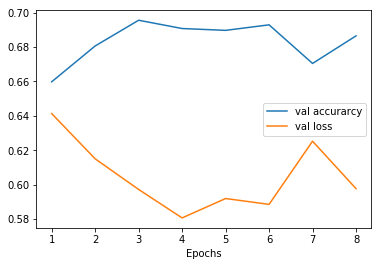

In [36]:
#mean of embeddings
    
embedding_dimensions=20
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = Embedding(input_dim=vocab_size, output_dim=embedding_dimensions)(sequence_input)
l_mean = Flatten()(AveragePooling1D(20)(embedded_sequences))

preds = Dense(1, activation='sigmoid')(l_mean)
model = keras.Model(sequence_input, preds)
model.summary()
experiment(model, texts, labels, 20)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 300, 20)           800000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 20)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 800,021
Trainable params: 800,021
Non-trainable params: 0
_________________________________________________________________


/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/30
 - 2s - loss: 0.7057 - acc: 0.5260 - val_loss: 0.6449 - val_acc: 0.6522
Epoch 2/30
 - 1s - loss: 0.6662 - acc: 0.5900 - val_loss: 0.6408 - val_acc: 0.6709
Epoch 3/30
 - 1s - loss: 0.6443 - acc: 0.6238 - val_loss: 0.6259 - val_acc: 0.6859
Epoch 4/30
 - 1s - loss: 0.6231 - acc: 0.6513 - val_loss: 0.6217 - val_acc: 0.6838
Epoch 5/30
 - 1s - loss: 0.6029 - acc: 0.6741 - val_loss: 0.5929 - val_acc: 0.6960
Epoch 6/30
 - 1s - loss: 0.5791 - acc: 0.6946 - val_loss: 0.5897 - val_acc: 0.6987
Epoch 7/30
 - 1s - loss: 0.5559 - acc: 0.7166 - val_loss: 0.5814 - val_acc: 0.7014
Epoch 8/30
 - 1s - loss: 0.5399 - acc: 0.7261 - val_loss: 0.5887 - val_acc: 0.6982
Epoch 9/30
 - 1s - loss: 0.5260 - acc: 0.7336 - val_loss: 0.5839 - val_acc: 0.6982
Epoch 10/30
 - 1s - loss: 0.5099 - acc: 0.7492 - val_loss: 0.5798 - val_acc: 0.7046
Epoch 11/30
 - 1s - loss: 0.4966 - acc: 0.7594 - val_loss: 0.5890 - val_acc: 0.6987
Epoch 12/30
 - 1s - loss: 0.4846 - a

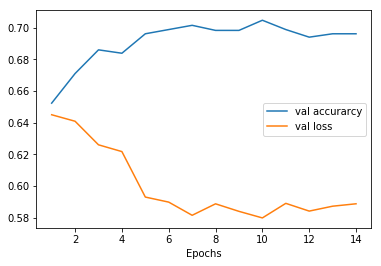

In [37]:
#mean of embeddings + drop
    
embedding_dimensions=20
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = Embedding(input_dim=vocab_size, output_dim=embedding_dimensions)(sequence_input)
l_mean = Dropout(0.2)(GlobalAveragePooling1D()(embedded_sequences))

preds = Dense(1, activation='sigmoid')(l_mean)
model = keras.Model(sequence_input, preds)
model.summary()
experiment(model, texts, labels)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 300, 20)           800000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 20)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 21        
Total params: 800,021
Trainable params: 800,021
Non-trainable params: 0
_________________________________________________________________


/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/30
 - 2s - loss: 0.6906 - acc: 0.5352 - val_loss: 0.6535 - val_acc: 0.6747
Epoch 2/30
 - 1s - loss: 0.6499 - acc: 0.6427 - val_loss: 0.6317 - val_acc: 0.6864
Epoch 3/30
 - 1s - loss: 0.6205 - acc: 0.6847 - val_loss: 0.6172 - val_acc: 0.6934
Epoch 4/30
 - 1s - loss: 0.5885 - acc: 0.7073 - val_loss: 0.6020 - val_acc: 0.6998
Epoch 5/30
 - 1s - loss: 0.5580 - acc: 0.7259 - val_loss: 0.5890 - val_acc: 0.6993
Epoch 6/30
 - 1s - loss: 0.5322 - acc: 0.7419 - val_loss: 0.5913 - val_acc: 0.6998
Epoch 7/30
 - 1s - loss: 0.5110 - acc: 0.7553 - val_loss: 0.5761 - val_acc: 0.7051
Epoch 8/30
 - 1s - loss: 0.4936 - acc: 0.7645 - val_loss: 0.5839 - val_acc: 0.6998
Epoch 9/30
 - 1s - loss: 0.4786 - acc: 0.7751 - val_loss: 0.5853 - val_acc: 0.6976
Epoch 10/30
 - 1s - loss: 0.4653 - acc: 0.7826 - val_loss: 0.5838 - val_acc: 0.6971

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/30
 - 1s - loss: 0.4558 - acc

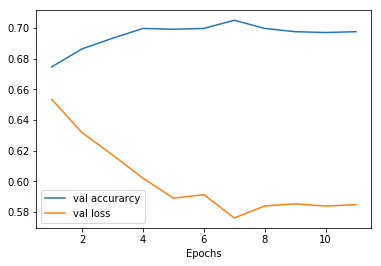

In [38]:
#avg and max

in_layer = Input(shape=(maxlen,), dtype='int32')
embed_layer = Embedding(input_dim=vocab_size, output_dim=20, input_length=maxlen)(in_layer)
avg_layer = GlobalAveragePooling1D()(embed_layer)
max_layer = GlobalMaxPooling1D()(embed_layer)
concat_layer = Dropout(0.2)(Concatenate()([avg_layer, max_layer]))
out_layer = Dense(1, activation='sigmoid')(avg_layer)#(concat_layer)
model = keras.Model(in_layer, out_layer)

model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['acc'])
model.summary()
experiment(model, texts, labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 300, 20)      800000      input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 299, 64)      2624        embedding_19[0][0]               
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 298, 64)      3904        embedding_19[0][0]               
__________________________________________________________________________________________________
conv1d_16 

/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/30
 - 4s - loss: 0.6766 - acc: 0.5845 - val_loss: 0.6205 - val_acc: 0.6667
Epoch 2/30
 - 3s - loss: 0.5748 - acc: 0.6933 - val_loss: 0.6031 - val_acc: 0.6747
Epoch 3/30
 - 3s - loss: 0.5275 - acc: 0.7296 - val_loss: 0.5914 - val_acc: 0.6779
Epoch 4/30
 - 3s - loss: 0.4853 - acc: 0.7587 - val_loss: 0.5598 - val_acc: 0.6725
Epoch 5/30
 - 3s - loss: 0.4530 - acc: 0.7809 - val_loss: 0.5727 - val_acc: 0.6832
Epoch 6/30
 - 3s - loss: 0.4245 - acc: 0.7978 - val_loss: 0.5831 - val_acc: 0.6827
Epoch 7/30
 - 3s - loss: 0.3876 - acc: 0.8246 - val_loss: 0.5509 - val_acc: 0.6955
Epoch 8/30
 - 3s - loss: 0.3492 - acc: 0.8485 - val_loss: 0.5701 - val_acc: 0.6982
Epoch 9/30
 - 3s - loss: 0.3114 - acc: 0.8699 - val_loss: 0.6180 - val_acc: 0.6806
Epoch 10/30
 - 3s - loss: 0.2779 - acc: 0.8850 - val_loss: 0.6125 - val_acc: 0.6923

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/30
 - 3s - loss: 0.2276 - acc

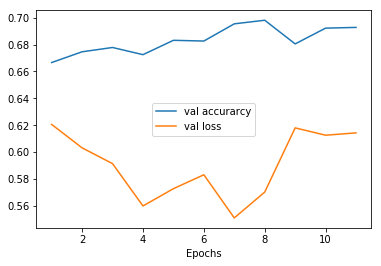

In [44]:
#avg and max + conv

in_layer = Input(shape=(maxlen,), dtype='int32')
embed_layer = Embedding(input_dim=vocab_size, output_dim=20, input_length=maxlen)(in_layer)
avg_layer = GlobalAveragePooling1D()(embed_layer)
max_layer = GlobalMaxPooling1D()(embed_layer)

conv_layers = []
for window_size in [2,3,4]:
    conv_layer = Conv1D(64,window_size)(embed_layer)
    conv_layer = Dropout(0.2)(conv_layer)
    conv_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(conv_layer)
convs_layer = Dropout(0.2)(Concatenate()(conv_layers))
    
concat_layer = Dropout(0.2)(Concatenate()([avg_layer, max_layer, convs_layer]))
out_layer = Dense(1, activation='sigmoid')(concat_layer)
model = keras.Model(in_layer, out_layer)

model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['acc'])
model.summary()
experiment(model, texts, labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 300, 20)      800000      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 300, 20)      0           embedding_29[0][0]               
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 299, 128)     5248        dropout_13[0][0]                 
__________________________________________________________________________________________________
conv1d_13 

/home/hellrich/bin/anaconda3/envs/keras-tensor-old-cudn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16839 samples, validate on 1872 samples
Epoch 1/50
 - 4s - loss: 0.7199 - acc: 0.5381 - val_loss: 0.6688 - val_acc: 0.6587
Epoch 2/50
 - 3s - loss: 0.6254 - acc: 0.6475 - val_loss: 0.6226 - val_acc: 0.6384
Epoch 3/50
 - 3s - loss: 0.5625 - acc: 0.7082 - val_loss: 0.5999 - val_acc: 0.6528
Epoch 4/50
 - 3s - loss: 0.5328 - acc: 0.7270 - val_loss: 0.5793 - val_acc: 0.6683
Epoch 5/50
 - 3s - loss: 0.5078 - acc: 0.7448 - val_loss: 0.5743 - val_acc: 0.6763
Epoch 6/50
 - 3s - loss: 0.4859 - acc: 0.7601 - val_loss: 0.5700 - val_acc: 0.6822
Epoch 7/50
 - 3s - loss: 0.4672 - acc: 0.7717 - val_loss: 0.5703 - val_acc: 0.6928
Epoch 8/50
 - 3s - loss: 0.4517 - acc: 0.7853 - val_loss: 0.5990 - val_acc: 0.6880
Epoch 9/50
 - 3s - loss: 0.4314 - acc: 0.7942 - val_loss: 0.5667 - val_acc: 0.6950
Epoch 10/50
 - 3s - loss: 0.4142 - acc: 0.8100 - val_loss: 0.5726 - val_acc: 0.7019
Epoch 11/50
 - 3s - loss: 0.3917 - acc: 0.8207 - val_loss: 0.5656 - val_acc: 0.7099
Epoch 12/50
 - 3s - loss: 0.3704 - a

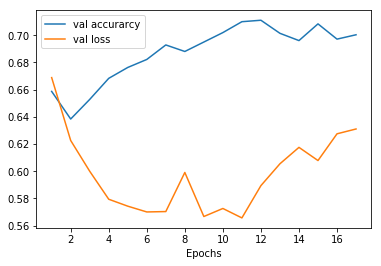

In [70]:
#Yoon Kim inspired architecture with cutom embeddings, 
#see (deprectaed code!)
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
 
in_layer = Input(shape=(maxlen,), dtype='int32')
embed_layer = Dropout(0.2)(Embedding(input_dim=vocab_size, output_dim=20, 
                                     input_length=maxlen)(in_layer))

convs = []
for window_size in [2,3,4,5]:
    conv_layer = Conv1D(128,window_size,activation='relu')(embed_layer)
    conv_layer = GlobalMaxPooling1D()(conv_layer)
    convs.append(conv_layer)
    
layer = Dropout(0.5)(Concatenate()(convs))
out_layer = Dense(1, activation='sigmoid')(layer)
model = keras.Model(in_layer, out_layer)

model.summary()
experiment(model, texts, labels, 50, 6)

entries 22696 found for 40000 words in embedding model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 300, 200)     8000000     input_31[0][0]                   
__________________________________________________________________________________________________
dropout_87 (Dropout)            (None, 300, 200)     0           embedding_56[0][0]               
__________________________________________________________________________________________________
conv1d_120 (Conv1D)             (None, 299, 128)     51328       dropout_87[0][0]                 
______________________________________________________

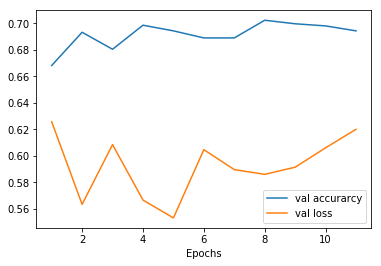

In [132]:
#Yoon Kim inspired architecture with pretrained embeddings, 
#see (deprectaed code!)
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
 
in_layer = Input(shape=(maxlen,), dtype='int32')
embed_layer = Dropout(0.2)((embeddings(word_index, input_dim=vocab_size, 
                    input_length=maxlen, embedding_dim=200))(in_layer))

convs = []
for window_size in [2,3,4,5]:
    conv_layer = Conv1D(128,window_size,activation='relu')(embed_layer)
    conv_layer = GlobalMaxPooling1D()(conv_layer)
    convs.append(conv_layer)
    
layer = Dropout(0.5)(Concatenate()(convs))
out_layer = Dense(1, activation='sigmoid')(layer)
model = keras.Model(in_layer, out_layer)

model.summary()
experiment(model, texts, labels, 50, 6)

entries 29714 found for 40000 words in embedding model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 200)     8000000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 300, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 299, 128)     51328       dropout_1[0][0]                  
______________________________________________________

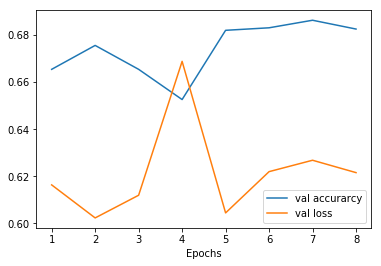

In [11]:
#Yoon Kim inspired architecture with pretrained embeddings + fine tuning 
#see (deprectaed code!)
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/

#fasttext
path = "/home/hellrich/keras-test/embeddings/wiki-news-"
suffix = "d-1M.vec"
embedding_dim=300

#bionlp
path = "/home/hellrich/keras-test/embeddings/bio_nlp_win2_"
path = "/home/hellrich/keras-test/embeddings/bio_nlp_win30_"
embedding_dim = 200
suffix = "d.vec"

in_layer = Input(shape=(maxlen,), dtype='int32')
embed_layer = Dropout(0.2)((embeddings(word_index, path=path, suffix=suffix, input_dim=vocab_size, 
                    input_length=maxlen, embedding_dim=embedding_dim))(in_layer))

convs = []
for window_size in [2,3,4,5]:
    conv_layer = Conv1D(128,window_size,activation='relu')(embed_layer)
    conv_layer = Dropout(0.2)(GlobalMaxPooling1D()(conv_layer))
    convs.append(conv_layer)
    
layer = Dropout(0.5)(Concatenate()(convs))
out_layer = Dense(1, activation='sigmoid')(layer)
model = keras.Model(in_layer, out_layer)

model.summary()
experiment(model, texts, labels, 50, 6, fine_tune_embeddings=(4,0.5))

In [14]:
#loading stuff for cell below
max_sentences = 10
MAX_SEQUENCE_LENGTH = 30
texts, labels, word_index = read_data(maxlen=maxlen, vocab_size=vocab_size, 
                                      return_word_index=True, sentence_wise=(max_sentences,MAX_SEQUENCE_LENGTH))

#bionlp
path = "/home/hellrich/keras-test/embeddings/bio_nlp_win2_"
#path = "/home/hellrich/keras-test/embeddings/bio_nlp_win30_"
embedding_dim = 200
suffix = "d.vec"
e =  embeddings(word_index, path=path, suffix=suffix, input_dim=vocab_size, input_length=maxlen, embedding_dim=embedding_dim)

entries 29714 found for 40000 words in embedding model


In [ ]:
#test with sentence and document level lstms, see https://github.com/keras-team/keras/issues/5516#issuecomment-295016548


# Encode each timestep
in_sentence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
embedded_sentence = e(in_sentence)
lstm_sentence = LSTM(64)(embedded_sentence)
encoded_model = keras.Model(in_sentence, lstm_sentence)

sequence_input = Input(shape=(max_sentences, MAX_SEQUENCE_LENGTH), dtype='int64')
seq_encoded = TimeDistributed(encoded_model)(sequence_input)
seq_encoded = Dropout(0.2)(seq_encoded)

# Encode entire sentence
seq_encoded = LSTM(64)(seq_encoded)

# Prediction
out_layer = Dense(1, activation='sigmoid')(seq_encoded)
model = keras.Model(sequence_input, out_layer)

model.summary()
experiment(model, texts, labels, 50, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10, 30)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 64)            8067840   
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 8,100,929
Trainable params: 100,929
Non-trainable params: 8,000,000
_________________________________________________________________
Train on 16839 samples, validate on 1871 samples
Epoch 1/50
 - 54s - loss: 0.5789 - acc: 0.6819 - val_loss: 0.5620 - val_acc: 